# Desafio DS - Lighthouse - P02

## 1. Understanding how to work

### 1.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing

### 1.2 Describing the file

In [2]:
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)

df_original = pd.read_csv("df_final_with_no_na_values.csv",index_col='Year', parse_dates=True)
df_original.index.name = None
df_original

,ASEAN-5,Advanced economies,Afghanistan,Africa (Region),Albania,...,Western Hemisphere (Region),World,Yemen,Zambia,Zimbabwe
1980-01-01,7.7,1.3,8.790000,4.374601,2.7,...,2.2,2.1,4.124158,3.9,2.406818
1981-01-01,6.5,2.0,11.850000,3.738894,5.7,...,2.0,1.9,6.742339,6.6,1.771111
1982-01-01,3.8,0.2,9.766667,4.741117,2.9,...,-1.4,0.7,1.151430,-2.9,2.773333
1983-01-01,4.5,3.2,8.933333,3.903339,1.1,...,2.1,2.6,7.742339,-1.1,1.935556
1984-01-01,4.6,4.8,10.816667,4.656672,2.0,...,6.1,4.6,11.078703,-1.7,2.688889
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,4.6,1.4,13.766667,4.200000,3.3,...,1.4,3.0,2.000000,4.1,2.600000
2025-01-01,4.6,1.8,14.533333,4.300000,3.4,...,1.9,3.2,7.000000,4.6,2.700000
2026-01-01,4.6,1.9,14.983333,4.300000,3.4,...,2.2,3.2,6.500000,4.7,2.800000
2027-01-01,4.5,1.8,14.500000,4.400000,3.4,...,2.2,3.1,6.000000,5.0,2.900000


In [3]:
df_original.iloc[:-5,:].describe().round()

,ASEAN-5,Advanced economies,Afghanistan,Africa (Region),Albania,...,Western Hemisphere (Region),World,Yemen,Zambia,Zimbabwe
count,44.0,44.0,44.0,44.0,44.0,...,44.0,44.0,44.0,44.0,44.0
mean,5.0,2.0,9.0,4.0,3.0,...,3.0,3.0,2.0,3.0,2.0
std,3.0,2.0,4.0,2.0,7.0,...,2.0,2.0,7.0,4.0,7.0
min,-9.0,-4.0,-2.0,-2.0,-28.0,...,-4.0,-3.0,-28.0,-13.0,-16.0
25%,4.0,2.0,6.0,3.0,2.0,...,2.0,3.0,1.0,1.0,-1.0
50%,5.0,3.0,9.0,4.0,4.0,...,3.0,3.0,4.0,4.0,2.0
75%,7.0,3.0,11.0,5.0,6.0,...,4.0,4.0,6.0,6.0,5.0
max,9.0,5.0,21.0,7.0,13.0,...,6.0,6.0,11.0,10.0,20.0


### 1.3 Creating a random list
I decided to create a random list to better see what is happing with the series.

In [4]:
import random

# random_columns_list = [random.randint(0,227) for _ in range(10)]
# print(random_columns_list)
# OUTPUT
random_list = [1, 8, 23, 33, 55, 86, 92, 100, 150, 214]
random_list_columns = df_original.iloc[:1,random_list].columns
random_list_columns

Index(['Advanced economies', 'Antigua and Barbuda', 'Benin', 'Cabo Verde',
       'Dominican Republic', 'Haiti', 'Indonesia', 'Jordan',
       'Pacific Islands ', 'United Kingdom'],
      dtype='object')

#### 1.3.1 Plot with seasonal decompose

In [5]:
def test_seasonal_decompose(df,list_columns):

    for column in list_columns:
        resultado = seasonal_decompose(df[column], period=10)
        fig = plt.figure(figsize=(8, 6))  
        fig = resultado.plot()

<Figure size 800x600 with 0 Axes>

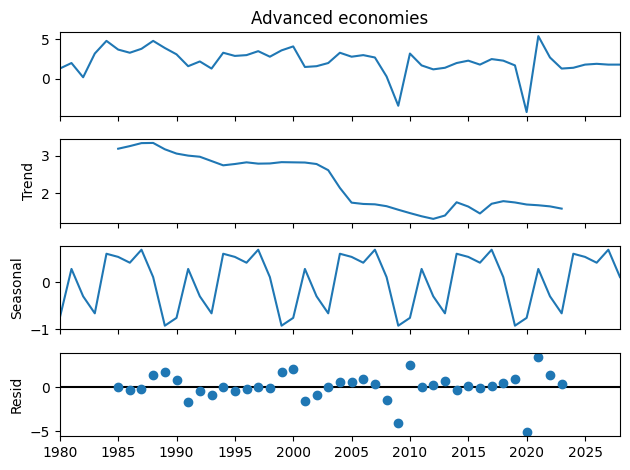

<Figure size 800x600 with 0 Axes>

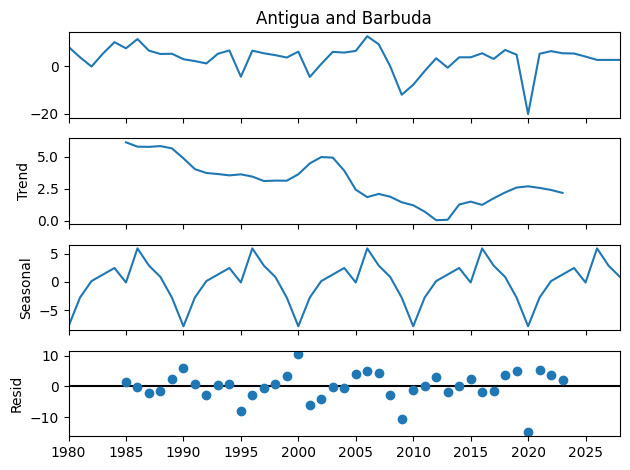

<Figure size 800x600 with 0 Axes>

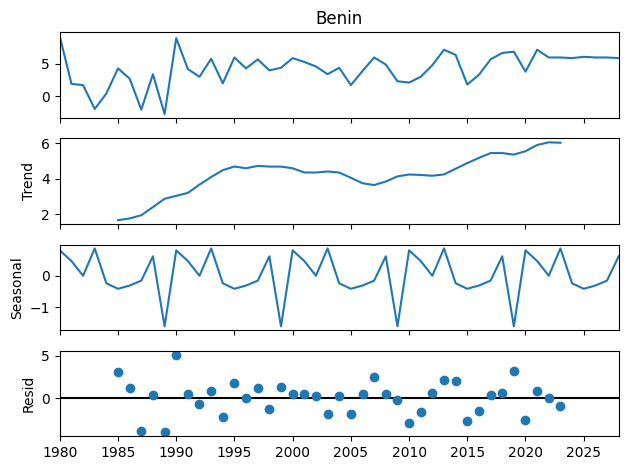

<Figure size 800x600 with 0 Axes>

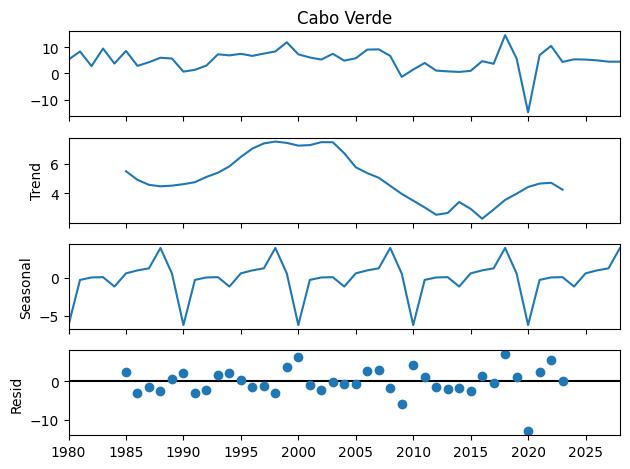

<Figure size 800x600 with 0 Axes>

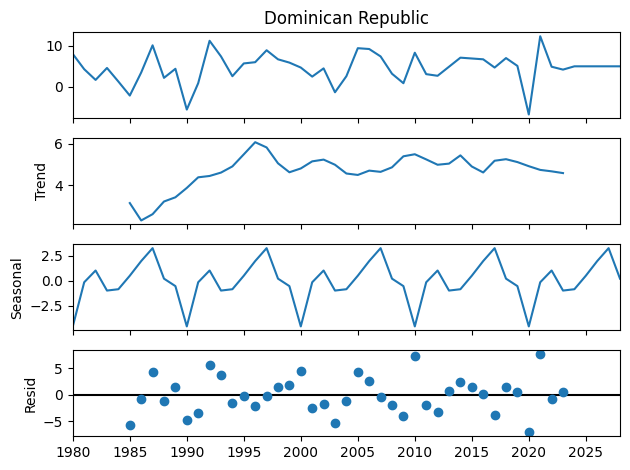

<Figure size 800x600 with 0 Axes>

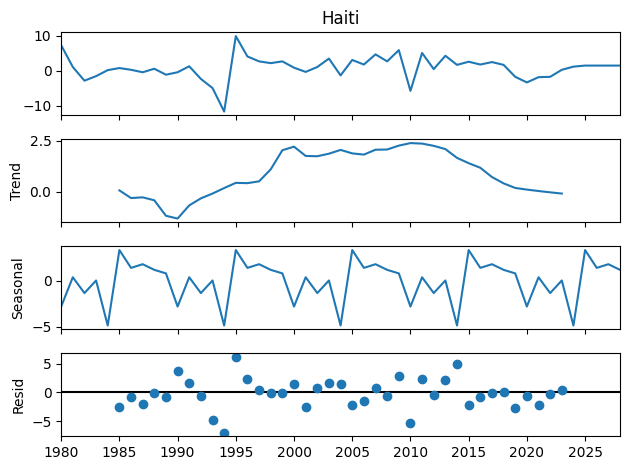

<Figure size 800x600 with 0 Axes>

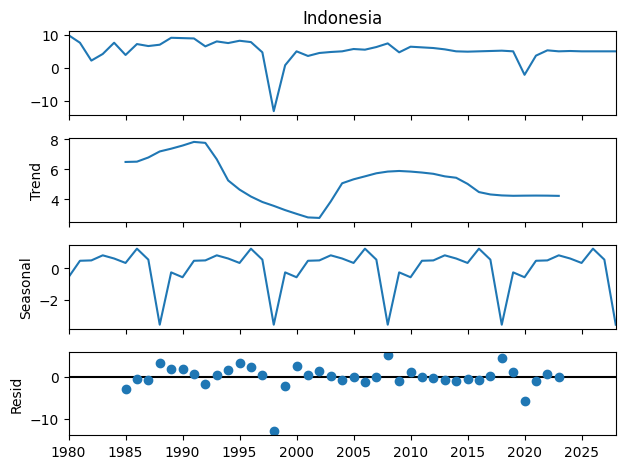

<Figure size 800x600 with 0 Axes>

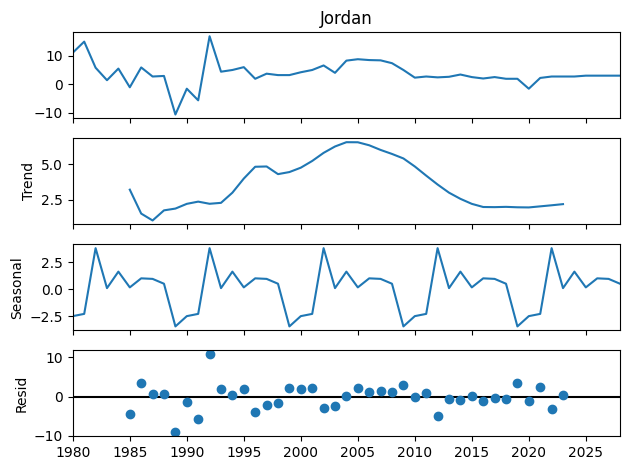

<Figure size 800x600 with 0 Axes>

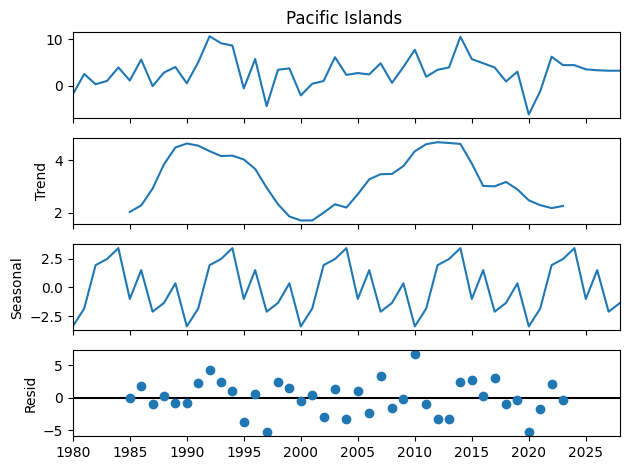

<Figure size 800x600 with 0 Axes>

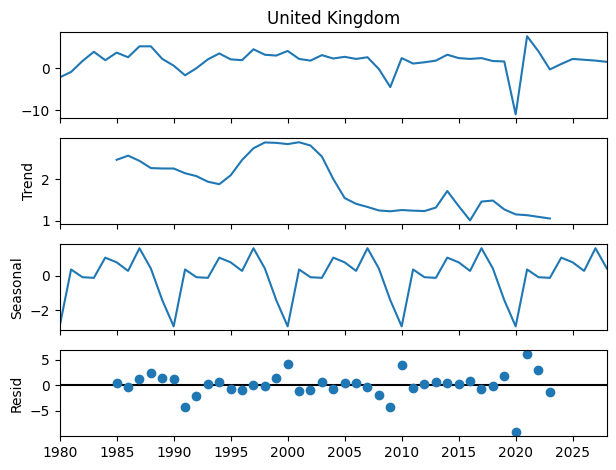

In [6]:
test_seasonal_decompose(df_original,random_list_columns)

## 2.  Creating functions

### 2.2 Metrics

In [65]:
def metrics(y_true, y_pred, list_name, model_name):

    dicio = []
    
    for i in list_name:

        y_true_2 = y_true[[i]].values
        y_pred_2 = y_pred[[i]].values

        mae = round(np.mean(np.abs((y_true_2 - y_pred_2) / y_true_2)) * 100, 2)
        rmse = round(np.sqrt(mean_squared_error(y_true_2, y_pred_2)), 2)
        mape = round(mean_absolute_percentage_error(y_true_2, y_pred_2), 2)

        dicio.append({'Country':i,'Model': model_name,'mae': mae, 'rmse': rmse, 'mape': mape})
    
    metrics = pd.DataFrame(dicio)

    return metrics

### 2.3 Adfuller

This function tests the Augmented Dickey-Fuller test using a sample of countries and creates two lists: one for countries with stationary time series and another for countries with non-stationary time series

In [8]:
def test_adfuller(df,sample_list):
    list_stationary = []
    list_non_stationary = []

    print("Result of p-value to sample data \n")
    
    for column in sample_list:
        result = adfuller(df_original[column].iloc[:-5])
        print(column)
        print(f'ADF: {result[0]}')
        print(f'p-value: {result[1]}')
        print('-'*50)
    
    for column in df.columns:
        result = adfuller(df_original[column].iloc[:-5])
        if result[1] <= 0.05:
            list_stationary.append(column)
        else:
            list_non_stationary.append(column)
    
    stationary_total = len(list_stationary)
    stationary_p = (stationary_total/len(df.columns)*100)

    non_stationary_total = len(list_non_stationary)
    non_stationary_p = (non_stationary_total/len(df.columns)*100)
    
    print(f"\nTotal of stationary is {stationary_total} and it represents {stationary_p} %")
    print(f"Total of Non stationary is {non_stationary_total} and it represents {non_stationary_p} %")
    
    return (list_stationary,list_non_stationary)

### 2.4 Auto ARIMA Model

In [50]:
def auto_arima_model(df_train, list_columns, trend= None, d=None, stationary=True, seasonal=True):

    df_prediction = pd.DataFrame()

    for column in list_columns:
        model_sarimax = auto_arima(
            df_train[column],
            start_p=0, max_p=2, 
            start_q=0, max_q=2,
            m=10, 
            seasonal=seasonal,
            stationary=stationary,
            d=d, 
            trend= trend,
            test = 'adf',
            error_acCtion='ignore', 
            stepwise=True
        )

        pred_sarimax = model_sarimax.predict(df_test.shape[0])
        
        df_prediction = pd.concat([df_prediction, pd.DataFrame(pred_sarimax,columns=[column])], axis=1).round()
    
    auto_arima_pred = pd.DataFrame(df_prediction)

    return auto_arima_pred

### 2.5 Simple Exponential Smoothing Model

#### 2.5.1 Smoothing level

This function finds the better smoothing level for each country

In [10]:
def find_smoothing_level(df_train, df_test, columns):
    smoothing_list = []

    for i in columns:
        
        best_mse = float('inf')
        best_smoothing_level = None
        smoothing_levels = np.linspace(0.01, 1, 10)

        for smoothing_level in smoothing_levels:
            model = SimpleExpSmoothing(df_train[i]).fit(smoothing_level=smoothing_level)
            forecast = model.forecast(steps=len(df_test[i]))
            mse = mean_squared_error(df_test[i], forecast)
            
            if mse < best_mse:
                best_mse = mse
                best_smoothing_level = smoothing_level

        smoothing_list.append({'Country':i,'best_smoothing_level': best_smoothing_level})

    smoothing_level = pd.DataFrame(smoothing_list)

    return smoothing_level

#### 2.5.2 Model 

In [11]:
def simple_smoothing(df_train, df_test, smoothing_level):

    df_prediction = pd.DataFrame()
    
    for i in smoothing_level.index:
        column = smoothing_level['Country'].iloc[i]
        # print(column)
        model_ses = SimpleExpSmoothing(
            df_train[column],
            initialization_method='estimated', #heurustic                             
        ).fit(smoothing_level=smoothing_level['best_smoothing_level'].iloc[i], optimized=True)
        
        pred_ses = model_ses.forecast(df_test.shape[0])

        df_prediction = pd.concat([df_prediction, pd.DataFrame(pred_ses,columns=[column])], axis=1).round()

    simple_smoothing_pred = pd.DataFrame(df_prediction)
    
    return simple_smoothing_pred

### 2.6 Plot Test and Prediction

In [12]:
def plot_test_pred(df_train,df_test,df_pred,random_columns_list, model_type):
    columns = df_pred.iloc[:1,random_columns_list].columns
    
    for i in columns:
        fig, axs = plt.subplots(figsize=(8, 3))

        axs.plot(df_train[i].index, df_train[i])
        axs.plot(df_pred[i].index, df_pred[i])
        axs.plot(df_test[i].index, df_test[i])
        axs.legend(['Train','Pred','Test'])
        axs.set_title(f'Model {model_type} - {i}')
        plt.show()

## 3. Applying models

### 3.1 Train series and Test series

In [13]:
df_train = df_original.iloc[:-5].copy()
df_test = df_original.iloc[44:].copy()

### 3.2 List of stationary and no stationary series

To find the list of countries that are stationary and no stationary and also testing de ADF with a sample

In [14]:
list_stationary,list_non_stationary = test_adfuller(df_train,random_list_columns)

Result of p-value to sample data 

Advanced economies
ADF: -5.837409806233895
p-value: 3.847553611545338e-07
--------------------------------------------------
Antigua and Barbuda
ADF: -5.069898689903504
p-value: 1.6110253897305036e-05
--------------------------------------------------
Benin
ADF: -1.4412566987296984
p-value: 0.5623452387611998
--------------------------------------------------
Cabo Verde
ADF: -5.256092413089159
p-value: 6.746861308313114e-06
--------------------------------------------------
Dominican Republic
ADF: -5.557715947405266
p-value: 1.567130523290954e-06
--------------------------------------------------
Haiti
ADF: -6.482719059129365
p-value: 1.283122371533606e-08
--------------------------------------------------
Indonesia
ADF: -4.698757220287516
p-value: 8.460631405072112e-05
--------------------------------------------------
Jordan
ADF: -3.8914010918303945
p-value: 0.0020990496578381047
--------------------------------------------------
Pacific Islands 
AD

In [15]:
list_stationary

['ASEAN-5',
 'Advanced economies',
 'Africa (Region)',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Asia and Pacific',
 'Australia',
 'Australia and New Zealand',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Barbados',
 'Belgium',
 'Belize',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Canada',
 'Caribbean',
 'Central African Republic',
 'Central America',
 'Central Asia and the Caucasus',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Costa Rica',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Denmark',
 'Dominica',
 'Dominican Republic',
 'East Asia',
 'Eastern Europe ',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Emerging and Developing Asia',
 'Emerging and Developing Europe',
 'Emerging market and developing economies',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Euro area',
 'Europe',
 'European Union',
 'Fed. States of

In [16]:
list_non_stationary

['Afghanistan',
 'Bangladesh',
 'Belarus',
 'Benin',
 'Brunei Darussalam',
 'Bulgaria',
 'Cameroon',
 'Dem. Rep. of the Congo',
 'Djibouti',
 'Equatorial Guinea',
 'Ethiopia',
 'Guyana',
 'Italy',
 'Kazakhstan',
 'Moldova',
 'Montenegro',
 'Mozambique',
 'Myanmar',
 'Niger',
 'Other advanced economies',
 'Puerto Rico',
 'Republic of Korea',
 'Russian Federation',
 'Somalia',
 'Sri Lanka',
 'Taiwan Province of China',
 'Tajikistan',
 'Tanzania',
 'The Bahamas',
 'Turkmenistan',
 'Uzbekistan',
 'Yemen',
 'Zambia',
 'Zimbabwe']

#### 3.2.1 Creating a random list with stationary series and non stationary list

In [17]:
# random_stationary_list = [random.randint(0,193) for _ in range(10)]
# random_non_stationary_list = [random.randint(0,33) for _ in range(10)]

# print(random_stationary_list)
# print(random_non_stationary_list)

# OUTPUT
random_stationary_list = [4, 15, 22, 58, 113, 131, 150, 181, 188, 189]
random_non_stationary_list = [3, 4, 11, 11, 16, 24, 25, 29, 30, 33]

### 3.3 Auto Arima

#### 3.3.1 Model Auto ARIMA

##### A) Stationary

In [55]:
df_pred_auto_arima_stationary = auto_arima_model(df_train, list_stationary)
df_pred_auto_arima_stationary

,ASEAN-5,Advanced economies,Africa (Region),Albania,Algeria,...,Vietnam,West Bank and Gaza,Western Europe,Western Hemisphere (Region),World
2024-01-01,5.0,2.0,4.0,4.0,2.0,...,3.0,6.0,2.0,3.0,3.0
2025-01-01,5.0,2.0,4.0,3.0,2.0,...,7.0,6.0,2.0,3.0,3.0
2026-01-01,5.0,2.0,5.0,3.0,2.0,...,7.0,6.0,2.0,3.0,3.0
2027-01-01,5.0,2.0,4.0,3.0,2.0,...,5.0,6.0,2.0,3.0,3.0
2028-01-01,5.0,2.0,4.0,3.0,2.0,...,6.0,6.0,2.0,3.0,3.0


##### B) Non Stationary

In [56]:
df_pred_auto_arima_non_stationary = auto_arima_model(df_train, list_non_stationary, stationary = False, d=1)
df_pred_auto_arima_non_stationary

,Afghanistan,Bangladesh,Belarus,Benin,Brunei Darussalam,...,Turkmenistan,Uzbekistan,Yemen,Zambia,Zimbabwe
2024-01-01,12.0,6.0,1.0,5.0,2.0,...,2.0,5.0,-2.0,3.0,2.0
2025-01-01,12.0,6.0,1.0,5.0,1.0,...,2.0,5.0,-2.0,3.0,2.0
2026-01-01,12.0,6.0,1.0,5.0,0.0,...,2.0,5.0,-2.0,3.0,2.0
2027-01-01,12.0,6.0,1.0,5.0,1.0,...,2.0,5.0,-2.0,3.0,2.0
2028-01-01,12.0,6.0,1.0,5.0,1.0,...,2.0,5.0,-2.0,3.0,2.0


#### 3.3.2 Metrics Auto ARIMA

##### A) Stationary

In [67]:
df_metric_auto_arima_stationary = metrics(df_test, df_pred_auto_arima_stationary,list_stationary,'Auto ARIMA')
df_metric_auto_arima_stationary

,Country,Model,mae,rmse,mape
0,ASEAN-5,Auto ARIMA,9.18,0.42,0.09
1,Advanced economies,Auto ARIMA,16.29,0.31,0.16
2,Africa (Region),Auto ARIMA,9.64,0.45,0.10
3,Albania,Auto ARIMA,13.65,0.48,0.14
4,Algeria,Auto ARIMA,13.14,0.33,0.13
...,...,...,...,...,...
189,Vietnam,Auto ARIMA,19.95,1.93,0.20
190,West Bank and Gaza,Auto ARIMA,174.44,3.79,1.74
191,Western Europe,Auto ARIMA,30.59,0.49,0.31
192,Western Hemisphere (Region),Auto ARIMA,56.25,1.07,0.56


##### B) Non Stationary

In [68]:
df_metric_auto_arima_non_stationary = metrics(df_test, df_pred_auto_arima_non_stationary,list_non_stationary,'Auto ARIMA')
df_metric_auto_arima_non_stationary

,Country,Model,mae,rmse,mape
0,Afghanistan,Auto ARIMA,16.84,2.47,0.17
1,Bangladesh,Auto ARIMA,14.84,1.11,0.15
2,Belarus,Auto ARIMA,33.81,0.28,0.34
3,Benin,Auto ARIMA,16.37,0.98,0.16
4,Brunei Darussalam,Auto ARIMA,69.42,2.08,0.69
...,...,...,...,...,...
29,Turkmenistan,Auto ARIMA,13.39,0.36,0.13
30,Uzbekistan,Auto ARIMA,9.09,0.50,0.09
31,Yemen,Auto ARIMA,145.81,7.61,1.46
32,Zambia,Auto ARIMA,35.79,1.74,0.36


##### C) Merge both metrics

In [69]:
df_metrics_auto_arima = pd.concat([df_metric_auto_arima_non_stationary,df_metric_auto_arima_stationary], axis=0)
df_metrics_auto_arima

,Country,Model,mae,rmse,mape
0,Afghanistan,Auto ARIMA,16.84,2.47,0.17
1,Bangladesh,Auto ARIMA,14.84,1.11,0.15
2,Belarus,Auto ARIMA,33.81,0.28,0.34
3,Benin,Auto ARIMA,16.37,0.98,0.16
4,Brunei Darussalam,Auto ARIMA,69.42,2.08,0.69
...,...,...,...,...,...
189,Vietnam,Auto ARIMA,19.95,1.93,0.20
190,West Bank and Gaza,Auto ARIMA,174.44,3.79,1.74
191,Western Europe,Auto ARIMA,30.59,0.49,0.31
192,Western Hemisphere (Region),Auto ARIMA,56.25,1.07,0.56


#### 3.3.3 Plots the prediction for some random series

plot_test_pred(df_train ,df_test,df_pred_auto_arima_stationary,random_stationary_list, 'Auto Arima')

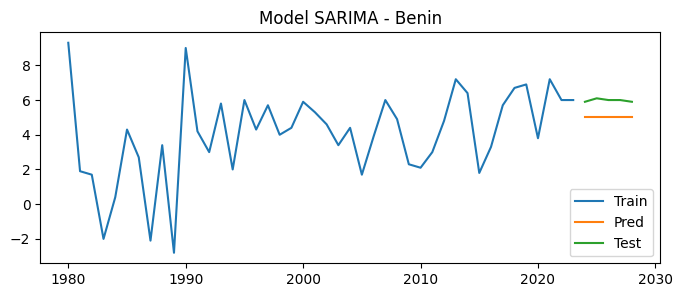

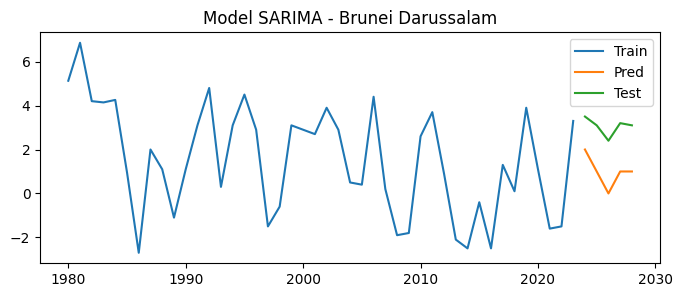

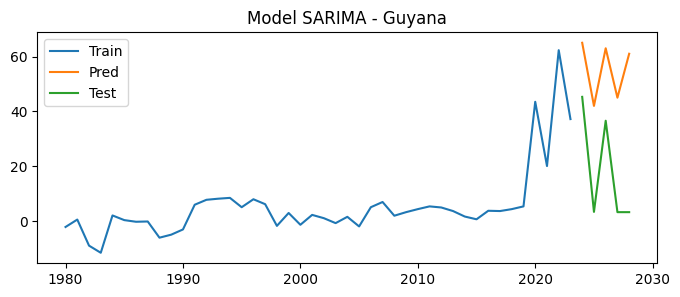

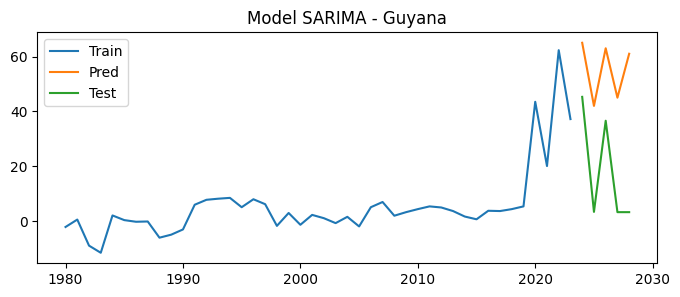

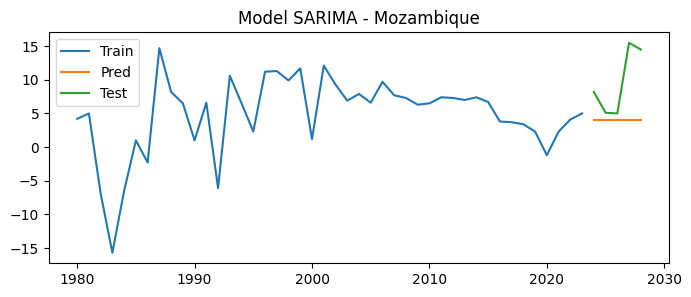

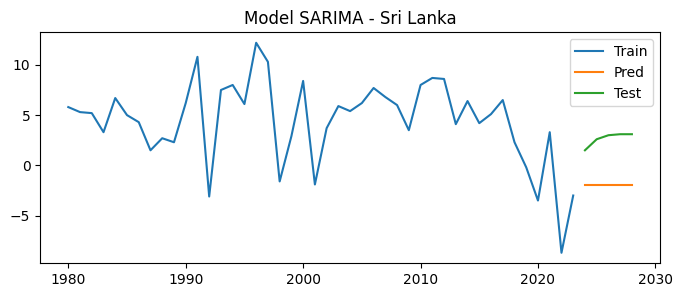

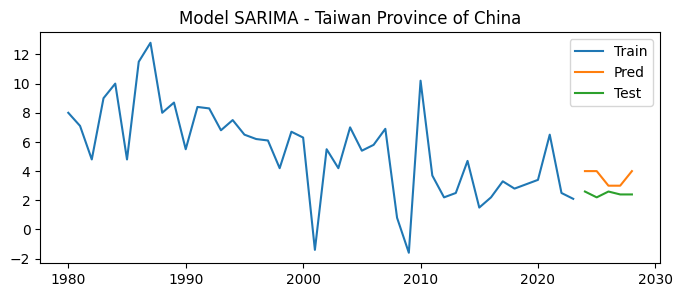

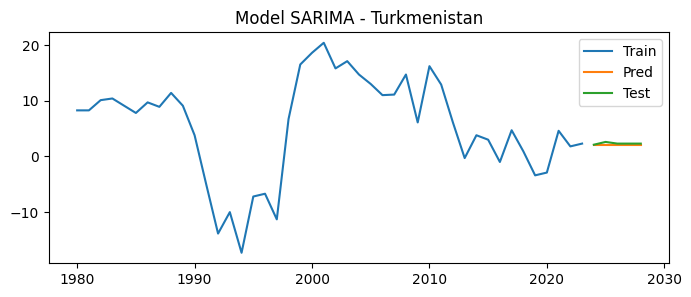

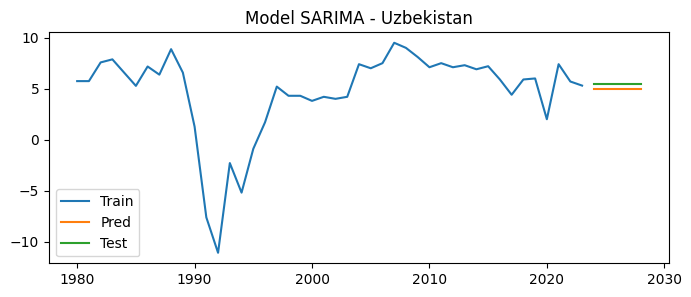

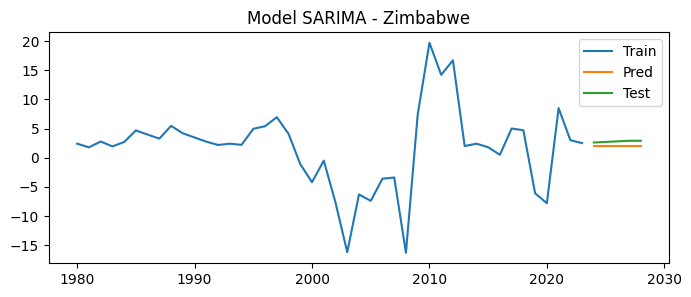

In [70]:
plot_test_pred(df_train ,df_test,df_pred_auto_arima_non_stationary,random_non_stationary_list,'SARIMA')

### 3.4 Simple Exponential Smoothing

#### 3.4.1 Smoothing level
Find smoothing level for each country

##### A) Stationary

In [71]:
smoothing_level_stationary = find_smoothing_level(df_train, df_test, list_stationary)

/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/hom

In [72]:
smoothing_level_stationary

,Country,best_smoothing_level
0,ASEAN-5,0.78
1,Advanced economies,0.23
2,Africa (Region),0.01
3,Albania,0.12
4,Algeria,0.45
...,...,...
189,Vietnam,0.78
190,West Bank and Gaza,0.23
191,Western Europe,0.34
192,Western Hemisphere (Region),0.12


##### B) Non Stationary

In [73]:
smoothing_level_non_stationary = find_smoothing_level(df_train, df_test, list_non_stationary)

/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/hom

In [74]:
smoothing_level_non_stationary

,Country,best_smoothing_level
0,Afghanistan,0.89
1,Bangladesh,0.23
2,Belarus,1.00
3,Benin,1.00
4,Brunei Darussalam,1.00
...,...,...
29,Turkmenistan,1.00
30,Uzbekistan,0.34
31,Yemen,0.01
32,Zambia,1.00


#### 3.4.2 Model Simple Exponential Smoothing

##### A) Stationary

In [75]:
df_pred_simple_smoothing_stationary =simple_smoothing(df_train, df_test, smoothing_level_stationary)
df_pred_simple_smoothing_stationary

/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/th

,ASEAN-5,Advanced economies,Africa (Region),Albania,Algeria,...,Vietnam,West Bank and Gaza,Western Europe,Western Hemisphere (Region),World
2024-01-01,5.0,2.0,4.0,3.0,2.0,...,6.0,2.0,2.0,2.0,3.0
2025-01-01,5.0,2.0,4.0,3.0,2.0,...,6.0,2.0,2.0,2.0,3.0
2026-01-01,5.0,2.0,4.0,3.0,2.0,...,6.0,2.0,2.0,2.0,3.0
2027-01-01,5.0,2.0,4.0,3.0,2.0,...,6.0,2.0,2.0,2.0,3.0
2028-01-01,5.0,2.0,4.0,3.0,2.0,...,6.0,2.0,2.0,2.0,3.0


##### B) Non Stationary

In [76]:
df_pred_simple_smoothing_non_stationary =simple_smoothing(df_train, df_test, smoothing_level_non_stationary)
df_pred_simple_smoothing_non_stationary

/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/thaina/indicium_particular/desafio_df_v3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/th

,Afghanistan,Bangladesh,Belarus,Benin,Brunei Darussalam,...,Turkmenistan,Uzbekistan,Yemen,Zambia,Zimbabwe
2024-01-01,12.0,6.0,1.0,6.0,3.0,...,2.0,6.0,2.0,4.0,3.0
2025-01-01,12.0,6.0,1.0,6.0,3.0,...,2.0,6.0,2.0,4.0,3.0
2026-01-01,12.0,6.0,1.0,6.0,3.0,...,2.0,6.0,2.0,4.0,3.0
2027-01-01,12.0,6.0,1.0,6.0,3.0,...,2.0,6.0,2.0,4.0,3.0
2028-01-01,12.0,6.0,1.0,6.0,3.0,...,2.0,6.0,2.0,4.0,3.0


#### 3.4.3 Metrics Simple Exponential Smoothing

##### A) Stationary

In [77]:
df_metric_simple_smoothing_stationary = metrics(df_test, df_pred_simple_smoothing_stationary,list_stationary,'Simple Smoothing')
df_metric_simple_smoothing_stationary

,Country,Model,mae,rmse,mape
0,ASEAN-5,Simple Smoothing,9.18,0.42,0.09
1,Advanced economies,Simple Smoothing,16.29,0.31,0.16
2,Africa (Region),Simple Smoothing,7.78,0.35,0.08
3,Albania,Simple Smoothing,11.23,0.38,0.11
4,Algeria,Simple Smoothing,13.14,0.33,0.13
...,...,...,...,...,...
189,Vietnam,Simple Smoothing,11.23,0.76,0.11
190,West Bank and Gaza,Simple Smoothing,8.52,0.36,0.09
191,Western Europe,Simple Smoothing,30.59,0.49,0.31
192,Western Hemisphere (Region),Simple Smoothing,15.08,0.31,0.15


##### B) Non Stationary

In [78]:
df_metric_simple_smoothing_non_stationary = metrics(df_test, df_pred_simple_smoothing_non_stationary,list_non_stationary,'Simple Smoothing')
df_metric_simple_smoothing_non_stationary

,Country,Model,mae,rmse,mape
0,Afghanistan,Simple Smoothing,16.84,2.47,0.17
1,Bangladesh,Simple Smoothing,14.84,1.11,0.15
2,Belarus,Simple Smoothing,33.81,0.28,0.34
3,Benin,Simple Smoothing,1.01,0.08,0.01
4,Brunei Darussalam,Simple Smoothing,10.40,0.37,0.10
...,...,...,...,...,...
29,Turkmenistan,Simple Smoothing,13.39,0.36,0.13
30,Uzbekistan,Simple Smoothing,9.09,0.50,0.09
31,Yemen,Simple Smoothing,54.19,3.83,0.54
32,Zambia,Simple Smoothing,14.39,0.78,0.14


##### C) Merge both metrics

In [79]:
df_metrics_simple_smoothing = pd.concat([df_metric_simple_smoothing_non_stationary,df_metric_simple_smoothing_stationary])
df_metrics_simple_smoothing

,Country,Model,mae,rmse,mape
0,Afghanistan,Simple Smoothing,16.84,2.47,0.17
1,Bangladesh,Simple Smoothing,14.84,1.11,0.15
2,Belarus,Simple Smoothing,33.81,0.28,0.34
3,Benin,Simple Smoothing,1.01,0.08,0.01
4,Brunei Darussalam,Simple Smoothing,10.40,0.37,0.10
...,...,...,...,...,...
189,Vietnam,Simple Smoothing,11.23,0.76,0.11
190,West Bank and Gaza,Simple Smoothing,8.52,0.36,0.09
191,Western Europe,Simple Smoothing,30.59,0.49,0.31
192,Western Hemisphere (Region),Simple Smoothing,15.08,0.31,0.15


#### 3.4.4 Plots the prediction for some random series

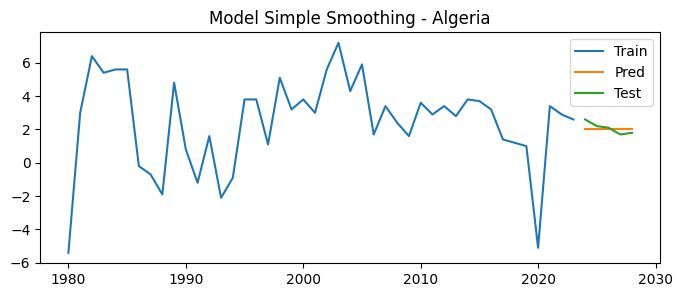

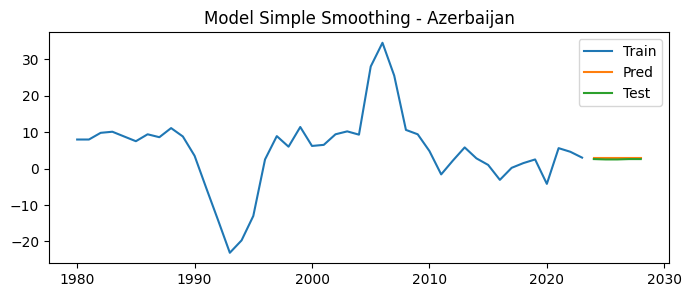

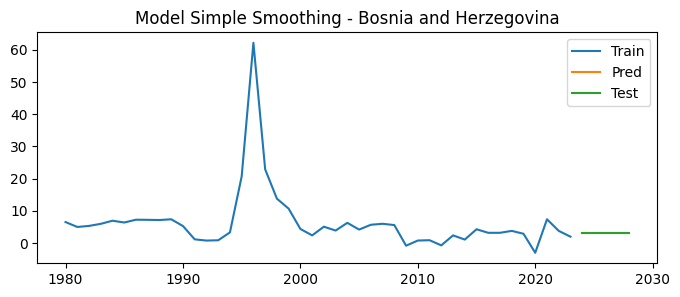

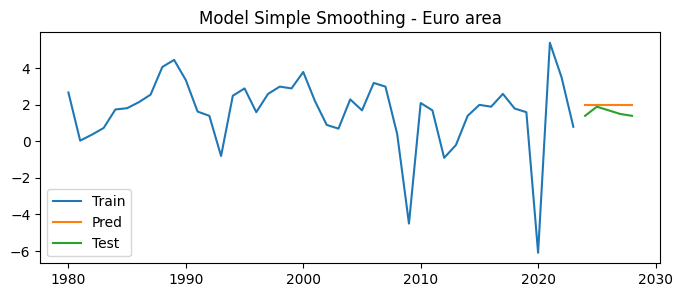

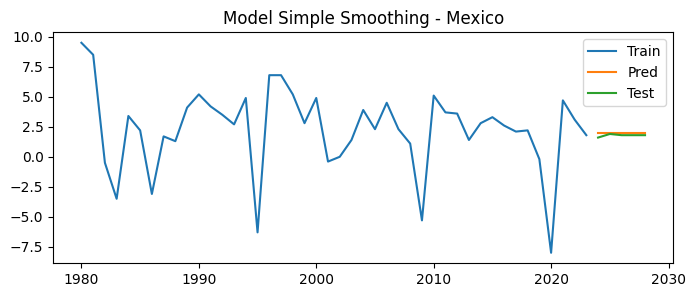

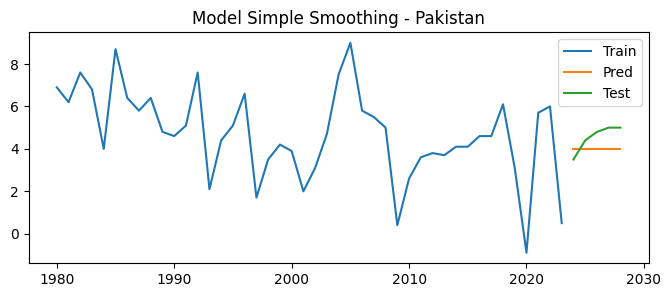

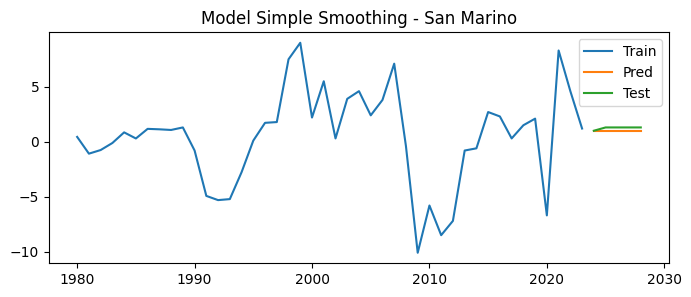

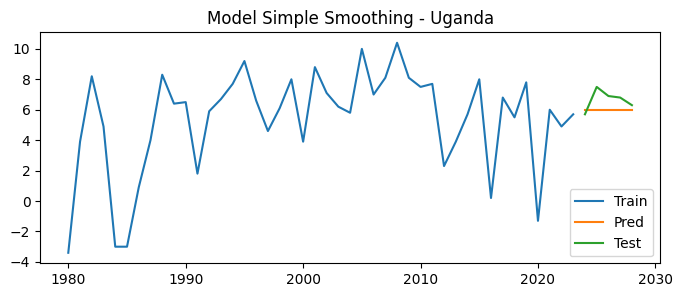

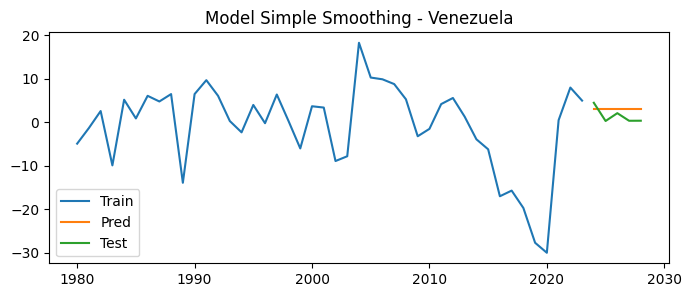

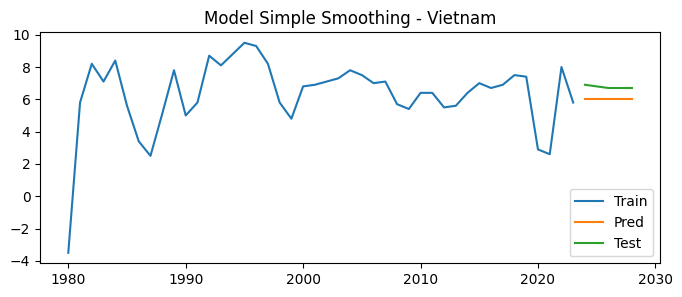

In [80]:
plot_test_pred(df_train ,df_test,df_pred_simple_smoothing_stationary,random_stationary_list, 'Simple Smoothing')

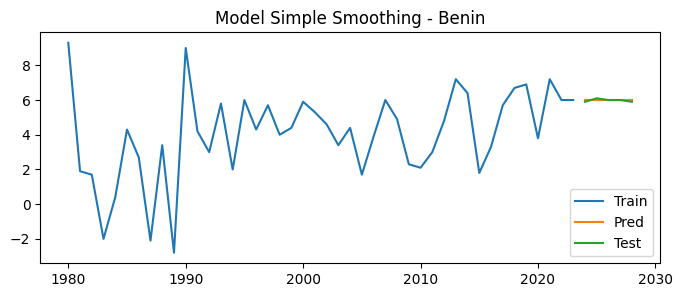

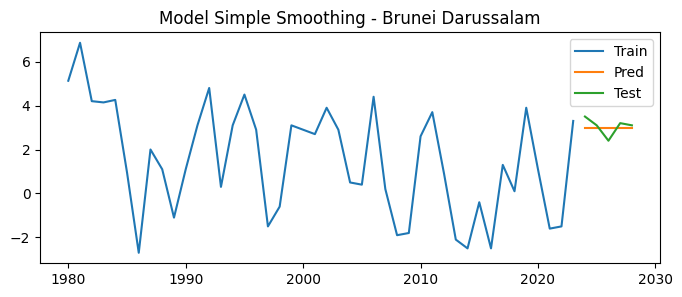

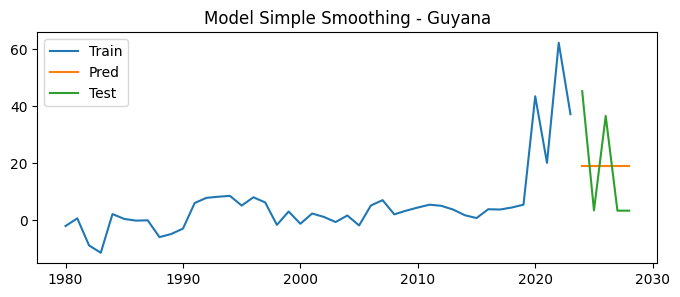

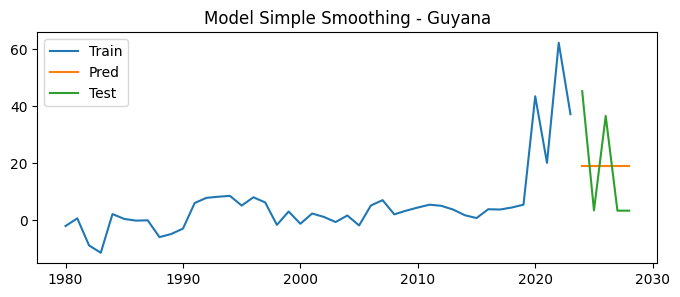

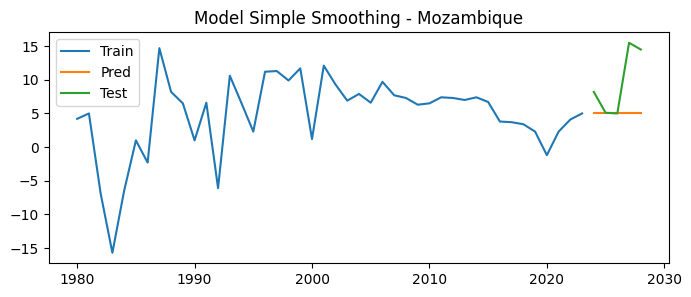

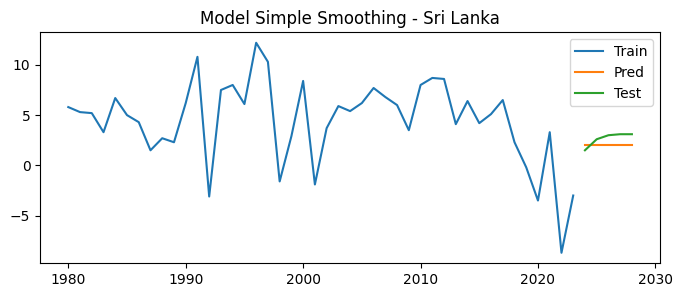

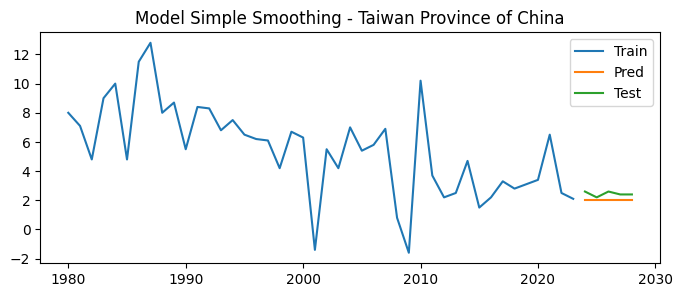

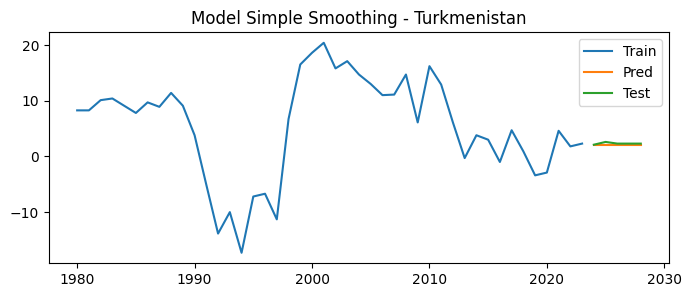

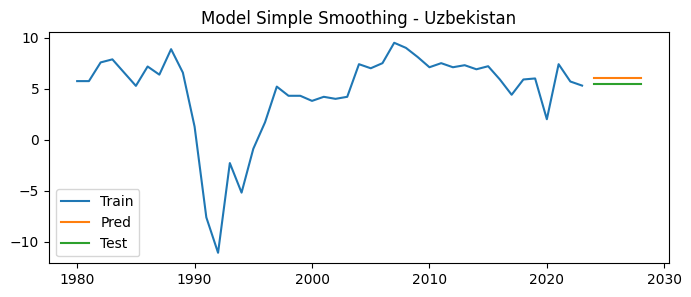

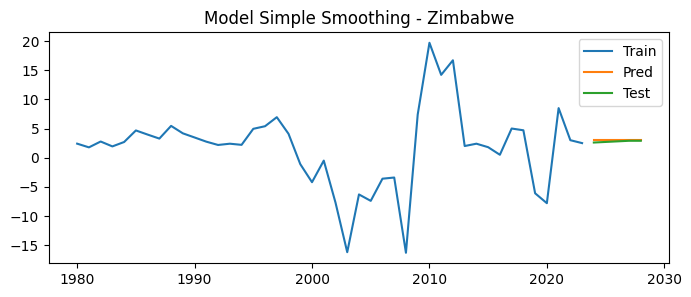

In [81]:
plot_test_pred(df_train ,df_test,df_pred_simple_smoothing_non_stationary,random_non_stationary_list,'Simple Smoothing')

## 4. Choosing the model

### 4.1 Creating a function to compare both models

In [82]:
def compare_and_calculate_percentages(df_a, df_b,column):
    if len(df_a) != len(df_b):
        raise ValueError("DataFrames must have the same number of rows.")

    total_rows = len(df_a)
    count_a_greater = 0
    count_b_greater = 0
    count_equal = 0

    for value_a, value_b in zip(df_a.iloc[:, column], df_b.iloc[:, column]):
        # print(df_a.iloc[index:index+1,-2:-1])
        if value_a > value_b:
            count_a_greater += 1
        elif value_a < value_b:
            count_b_greater += 1
        else:
            count_equal += 1

    percent_a_greater = (count_a_greater / total_rows) * 100
    percent_b_greater = (count_b_greater / total_rows) * 100
    percent_equal = (count_equal / total_rows) * 100

    print(f"Percentage of times A was greater than B: {percent_a_greater:.2f}%")
    print(f"Percentage of times B was greater than A: {percent_b_greater:.2f}%")
    print(f"Percentage of times A and B were equal: {percent_equal:.2f}%")

### 4.2 Comparing the models

In [92]:
print('rsme')
compare_and_calculate_percentages(df_metrics_auto_arima, df_metrics_simple_smoothing, column=-1)
print('-'*60)
print('mape')
compare_and_calculate_percentages(df_metrics_auto_arima, df_metrics_simple_smoothing, column=-2)

rsme
Percentage of times A was greater than B: 65.35%
Percentage of times B was greater than A: 6.14%
Percentage of times A and B were equal: 28.51%
------------------------------------------------------------
mape
Percentage of times A was greater than B: 66.67%
Percentage of times B was greater than A: 4.82%
Percentage of times A and B were equal: 28.51%


## 5. Final model

Since simple exponential smoothing yielded better parameters compared to SARIMA, I have decided to use it as the final model for predicting the series.

#### 5.1 Concat the stationary and non stationary

In [84]:
final_pred_model = pd.concat([df_pred_simple_smoothing_non_stationary,df_pred_simple_smoothing_stationary], axis = 1)
final_pred_model

,Afghanistan,Bangladesh,Belarus,Benin,Brunei Darussalam,...,Vietnam,West Bank and Gaza,Western Europe,Western Hemisphere (Region),World
2024-01-01,12.0,6.0,1.0,6.0,3.0,...,6.0,2.0,2.0,2.0,3.0
2025-01-01,12.0,6.0,1.0,6.0,3.0,...,6.0,2.0,2.0,2.0,3.0
2026-01-01,12.0,6.0,1.0,6.0,3.0,...,6.0,2.0,2.0,2.0,3.0
2027-01-01,12.0,6.0,1.0,6.0,3.0,...,6.0,2.0,2.0,2.0,3.0
2028-01-01,12.0,6.0,1.0,6.0,3.0,...,6.0,2.0,2.0,2.0,3.0


#### 5.2 Reorganizing the df

In [85]:
first_column= final_pred_model.iloc[:, 0]

remaining_columns= final_pred_model.iloc[:, 1:].reindex(sorted(final_pred_model.columns[1:]), axis=1)

df_result_pred = pd.concat([first_column, remaining_columns], axis=1)

df_result_pred 

,Afghanistan,ASEAN-5,Advanced economies,Africa (Region),Albania,...,Western Hemisphere (Region),World,Yemen,Zambia,Zimbabwe
2024-01-01,12.0,5.0,2.0,4.0,3.0,...,2.0,3.0,2.0,4.0,3.0
2025-01-01,12.0,5.0,2.0,4.0,3.0,...,2.0,3.0,2.0,4.0,3.0
2026-01-01,12.0,5.0,2.0,4.0,3.0,...,2.0,3.0,2.0,4.0,3.0
2027-01-01,12.0,5.0,2.0,4.0,3.0,...,2.0,3.0,2.0,4.0,3.0
2028-01-01,12.0,5.0,2.0,4.0,3.0,...,2.0,3.0,2.0,4.0,3.0


#### 5.3 Merge train and test

In [86]:
df_final = pd.concat([df_train,df_result_pred])

#### 5.4 Reindex and transpose

In [87]:
df_final.reset_index()
df_final.index = df_final.index.year

df_final = df_final.reset_index()
df_final.rename(columns ={'index':'Real GDP growth (Annual percent change)'}, inplace= True)

df_final

,Real GDP growth (Annual percent change),ASEAN-5,Advanced economies,Afghanistan,Africa (Region),...,Western Hemisphere (Region),World,Yemen,Zambia,Zimbabwe
0,1980,7.7,1.3,8.790000,4.374601,...,2.2,2.1,4.124158,3.9,2.406818
1,1981,6.5,2.0,11.850000,3.738894,...,2.0,1.9,6.742339,6.6,1.771111
2,1982,3.8,0.2,9.766667,4.741117,...,-1.4,0.7,1.151430,-2.9,2.773333
3,1983,4.5,3.2,8.933333,3.903339,...,2.1,2.6,7.742339,-1.1,1.935556
4,1984,4.6,4.8,10.816667,4.656672,...,6.1,4.6,11.078703,-1.7,2.688889
...,...,...,...,...,...,...,...,...,...,...,...
44,2024,5.0,2.0,12.000000,4.000000,...,2.0,3.0,2.000000,4.0,3.000000
45,2025,5.0,2.0,12.000000,4.000000,...,2.0,3.0,2.000000,4.0,3.000000
46,2026,5.0,2.0,12.000000,4.000000,...,2.0,3.0,2.000000,4.0,3.000000
47,2027,5.0,2.0,12.000000,4.000000,...,2.0,3.0,2.000000,4.0,3.000000


In [88]:
df_final_transpose = df_final.set_index('Real GDP growth (Annual percent change)').transpose().reset_index(names=['Real GDP growth (Annual percent change)']).rename_axis('', axis=1).round(2)
df_final_transpose

,Real GDP growth (Annual percent change),1980,1981,1982,1983,...,2024,2025,2026,2027,2028
0,ASEAN-5,7.70,6.50,3.80,4.50,...,5.0,5.0,5.0,5.0,5.0
1,Advanced economies,1.30,2.00,0.20,3.20,...,2.0,2.0,2.0,2.0,2.0
2,Afghanistan,8.79,11.85,9.77,8.93,...,12.0,12.0,12.0,12.0,12.0
3,Africa (Region),4.37,3.74,4.74,3.90,...,4.0,4.0,4.0,4.0,4.0
4,Albania,2.70,5.70,2.90,1.10,...,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
223,Western Hemisphere (Region),2.20,2.00,-1.40,2.10,...,2.0,2.0,2.0,2.0,2.0
224,World,2.10,1.90,0.70,2.60,...,3.0,3.0,3.0,3.0,3.0
225,Yemen,4.12,6.74,1.15,7.74,...,2.0,2.0,2.0,2.0,2.0
226,Zambia,3.90,6.60,-2.90,-1.10,...,4.0,4.0,4.0,4.0,4.0


In [90]:
df_final_transpose.replace(
    {
        "The Bahamas":"Bahamas, The",
        "China":"China, People's Republic of",
        "Dem. Rep. of the Congo":"Congo, Dem. Rep. of the",
        "Republic of Congo":"Congo, Republic of ",
        "The Gambia":"Gambia, The",
        "Republic of Korea":"Korea, Republic of",
        "Fed. States of Micronesia":"Micronesia, Fed. States of",
        "Republic of South Sudan":"South Sudan, Republic of",
        "Republic of Turkiye":"Türkiye, Republic of",
        "North Macedonia":"North Macedonia ",
        "Sub-Saharan Africa (Region)":"Sub-Saharan Africa (Region) ",
    }, 
    inplace = True)

## 6. Saving to csv

In [91]:
df_final_transpose.to_csv('files/predicted.csv', index = False)